In [1]:
import pandas as pd

In [2]:
df_capital = pd.read_csv('datasets/lacapital.csv')

df_capital.dropna(inplace=True)

df_norm = df_capital.copy()

# Limpieza y normalización de texto 

In [3]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('spanish'))
stop_words_extra = ['año', 'años', 'dos', 'tres', 'si', 'sí']

for word in stop_words_extra:
    stop_words.add(word)

def remove_accents(input_str):
  nfkd_form = unicodedata.normalize('NFKD', input_str)
  return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_stopwords(text):
  word_tokens = word_tokenize(text)
  filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
  return " ".join(filtered_text)

for col in df_capital.columns[:-2]:
    df_norm[col] = df_norm[col].str.lower()
    df_norm[col] = df_norm[col].str.replace('[^\w\s]', '', regex=True)
    df_norm[col] = df_norm[col].apply(remove_stopwords)
    df_norm[col] = df_norm[col].apply(remove_accents)

[nltk_data] Downloading package stopwords to /home/isaias/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/isaias/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Ejercicio 2

In [4]:
df_capital['categoria'].value_counts()

categoria
Ovación                  57
Política                 48
La Ciudad                32
Zoom                     31
Policiales               22
Información General      17
Economía                 16
La Región                16
Mundial de Rugby 2023     8
El Mundo                  6
Educación                 4
Turismo                   4
Negocios                  2
La región                 2
Cristina                  1
Opinión                   1
Julián Montoya            1
Baby Etchecopar           1
Colón                     1
Pepín rodríguez simón     1
Name: count, dtype: int64

In [5]:
categorias = df_norm['categoria'].value_counts()
categorias = categorias[categorias >= 10].index[:5]

In [6]:
categorias_df = list()

for categoria in categorias:
    temp_df = df_norm[df_norm['categoria'] == categoria]
    categorias_df.append(temp_df.sample(22, random_state=1))

In [7]:
x = list()
y = list()

for df in categorias_df:
    x += df['titulo'].tolist()
    y += df['categoria'].tolist()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

In [9]:
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=1)

In [10]:
vectorizer = TfidfVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

modelo_LR = LogisticRegression(max_iter=1000)
modelo_LR.fit(x_train_vectorized, y_train)

LogisticRegression(max_iter=1000)

In [11]:
y_pred_LR = modelo_LR.predict(x_test_vectorized)
acc_LR = accuracy_score(y_test, y_pred_LR)
report_LR = classification_report(y_test, y_pred_LR, zero_division=1)

In [12]:
print("Precisión Regresión Logística:", acc_LR)
print("Reporte de clasificación Regresión Logística:\n", report_LR)

Precisión Regresión Logística: 0.5454545454545454
Reporte de clasificación Regresión Logística:
               precision    recall  f1-score   support

      ciudad       1.00      0.40      0.57         5
     ovacion       0.18      1.00      0.31         2
  policiales       1.00      0.44      0.62         9
    politica       0.67      0.67      0.67         3
        zoom       1.00      0.67      0.80         3

    accuracy                           0.55        22
   macro avg       0.77      0.64      0.59        22
weighted avg       0.88      0.55      0.61        22



# Ejercicio 3

In [49]:
# !pip install pyspellchecker
# !pip install autocorrect

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [51]:
from autocorrect import Speller
from spellchecker import SpellChecker

# Configurar el corrector ortográfico para español
spell_1 = Speller(lang='es')

dictionary for this language not found, downloading...
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!


In [53]:
# Aplicar la corrección ortográfica
df_norm['texto'] = df_norm['texto']\
                   .apply(
                        lambda x: ' '.join(
                            spell_1(i) for i in x.split())
                         )

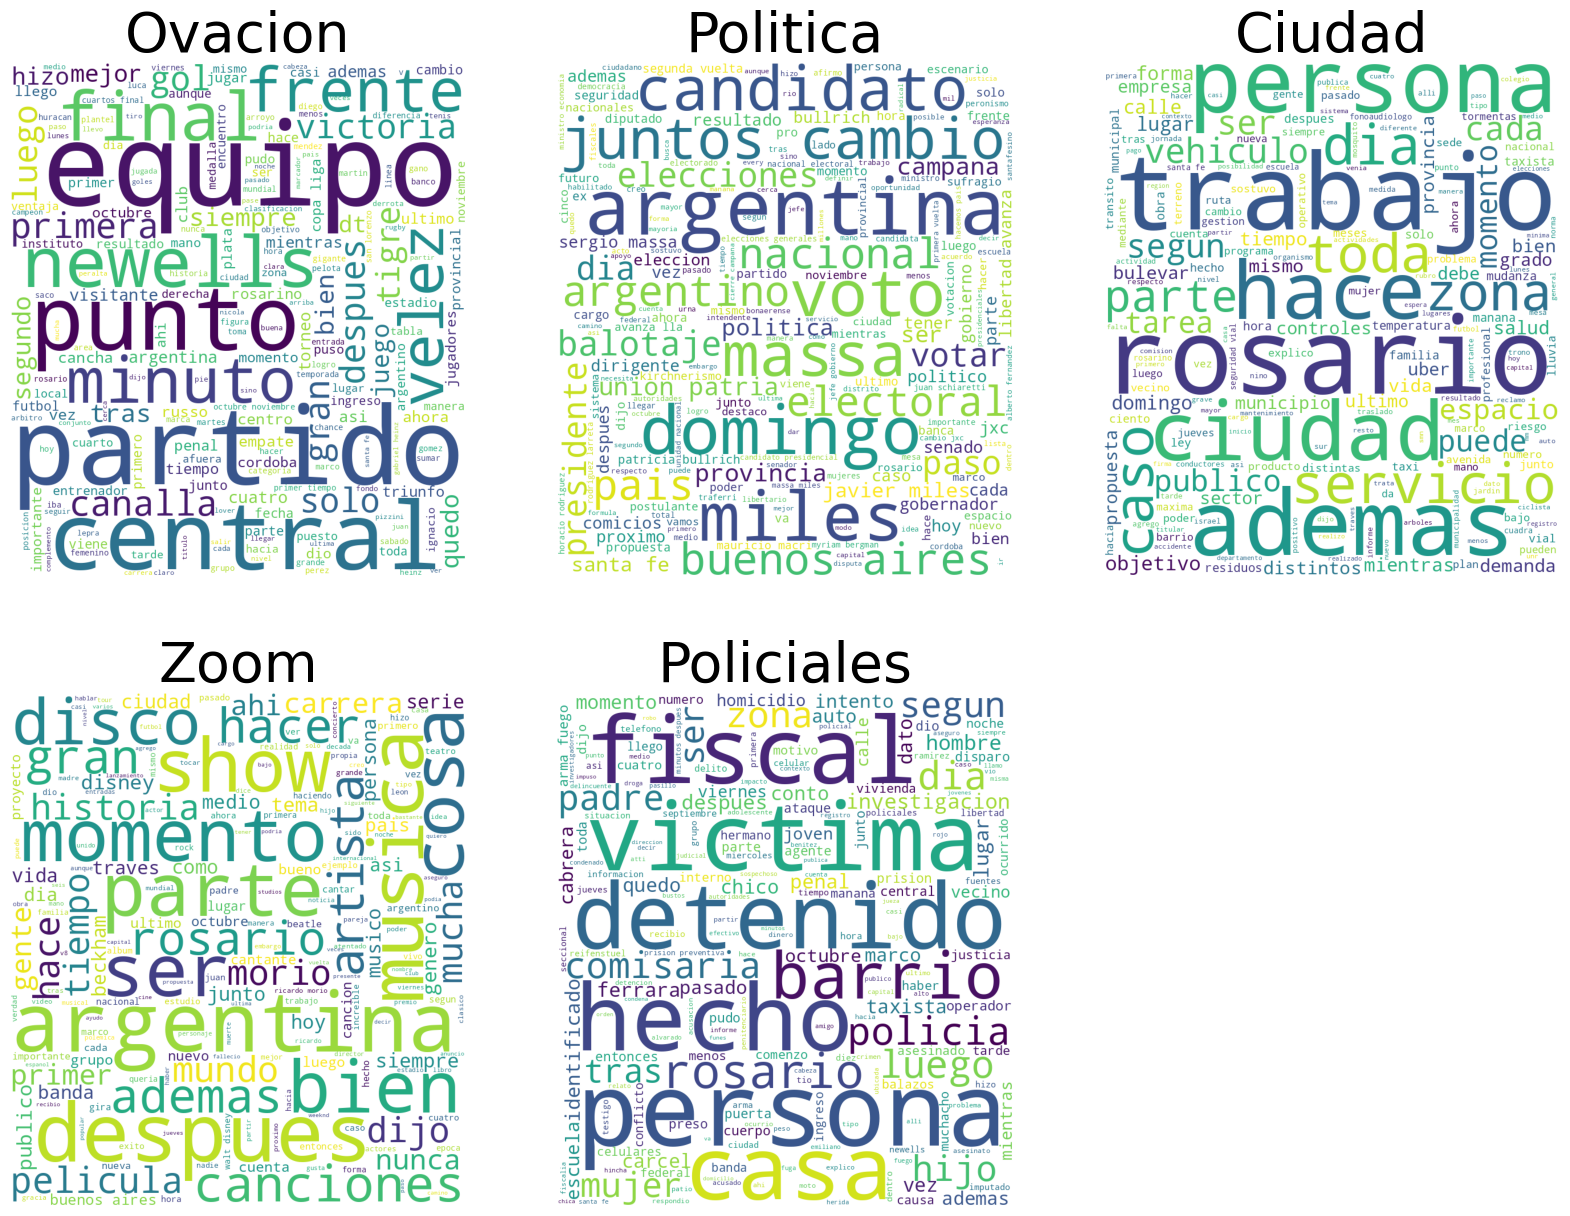

In [54]:
fig = plt.figure(figsize=(20, 15))

for idx, categoria in enumerate(categorias):
    texto = ' '.join(df_norm[df_norm['categoria'] == categoria]['texto'])

    wordcloud = WordCloud(width=800, height=900,
                            background_color='white',
                            stopwords=None,
                            min_font_size=10).generate(texto)


    ax = fig.add_subplot(2, 3, idx + 1)
    ax.imshow(wordcloud)
    plt.title(f'{categoria.capitalize()}', fontsize=40)
    plt.axis("off")


# Ejercicio 4

In [39]:
# !pip install sentence-transformers
# !pip install prettytable

In [44]:
from sentence_transformers import SentenceTransformer, util
from prettytable import PrettyTable

# Cargamos el modelo preentrenado multilingüe
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Definimos una lista de titulos_ovacion
titulos_ovacion = []
for ii in ovacion.titulo:
  titulos_ovacion.append(ii)
titulos_ovacion
# Codificamos las titulos_ovacion
embeddings = modelo.encode(titulos_ovacion, convert_to_tensor=True)
# Calculamos las puntuaciones de similitud
puntuaciones_coseno = util.cos_sim(embeddings, embeddings)
# Encontramos las puntuaciones de similitud más altas
pares = []
for i in range(len(puntuaciones_coseno)-1):
  for j in range(i+1, len(puntuaciones_coseno)):
    pares.append({'index': [i, j], 'score': puntuaciones_coseno[i][j]})
# Ordenamos las puntuaciones en orden decreciente
pares = sorted(pares, key=lambda x: x['score'], reverse=True)
# Creamos una tabla para mostrar los resultados
tabla = PrettyTable()
tabla.field_names = ["Oración 1", "Oración 2", "Puntuación de Similitud"]
# Añadimos las filas a la tabla
for par in pares[0:30]:
  i, j = par['index']
  tabla.add_row([titulos_ovacion[i], titulos_ovacion[j], f"{par['score']:.4f}"])
# Mostramos la tabla

print(tabla)

+---------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------+-------------------------+
|                                       Oración 1                                       |                                              Oración 2                                              | Puntuación de Similitud |
+---------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------+-------------------------+
|                Newell's: las variantes lo enderezaron y venció a Tigre                |                        Newell's va a Tigre a tratar de reafirmar su reacción                        |          0.7713         |
|                   Newell's y un triunfo que lo catapulta a las copas                  |                           Newell's con

# Ejercicio 5

In [27]:
noticia = ovacion['texto'][18]
noticia

'Rosario fue elegida para realizar el primer encuentro provincial de ligas sub-12 en el fútbol femenino, que se realizará este sábado a partir de las 10 y se llevará a cabo en el predio de la Asociación Rosarina de Fútbol, exBatallón 121, ubicado en Ayacucho al 5000, muy cerca del Museo del Deporte. El encuentro contará con 7 asociaciones oficiales: Santafesina, Rosarina A y B, Casildense, Rafaelina, Esperancina, Sanlorencina y San Martín. Los partidos serán para compartir, disfrutar y con el objetivo de que sea una jornada recreativa histórica. La entrada será gratuita.\nLa modalidad de la misma será de la siguiente manera: cada equipo contará con un plantel de 18 jugadoras de las categorías 2012. Vale aclarar que serán 9 titulares y luego se podrán realizar variantes.\nLa duración de los partidos será de 30 minutos y los cambios se realizarán a los 15 minutos. Se permitirá la sustitución de las 9 jugadoras que iniciaron el juego. Por último cabe mencionar que los compromisos se jugar

In [24]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Cargar el modelo de spaCy
# !python -m spacy download es_core_news_md
nlp = spacy.load('es_core_news_md')

In [28]:
# Función para generar un resumen extractivo usando PageRank
def summarize(text, num_sentences=5):
    
    lemmatized_sentences = list()
    original_sentences   = list()
    doc = nlp(text)
    
    for sent in doc.sents:
        lemmatized_sentence = ' '.join(
                                        token.lemma_ for token in sent
                                        if not token.is_stop and 
                                        not token.is_punct)

        if lemmatized_sentence.strip() != '':
            lemmatized_sentences.append(lemmatized_sentence)
            original_sentences.append(str(sent).strip())

    # Procesar las oraciones lematizadas con spaCy para obtener sus vectores
    lemmatized_docs = [nlp(sent) for sent in lemmatized_sentences]

    # Obtenemos una lista con los vectores de cada oración
    sentence_vectors = [sent.vector for sent in lemmatized_docs]

    # Devuelve una matriz de similitud entre las oraciones filtradas
    similarity_matrix = cosine_similarity(sentence_vectors)
    
    # Crear un grafo a partir de la matriz de similitud
    nx_graph = nx.from_numpy_array(similarity_matrix)
    
    # Aplicar PageRank al grafo
    scores = nx.pagerank(nx_graph)
    
    # Ordenar las oraciones por su puntuación y seleccionar las mejores
    ranked_sentences = sorted(
                            (
                                (scores[i], s) for i, s
                                in enumerate(original_sentences)
                            ),
                            reverse=True)
    
    return ' '.join(ranked_sentences[i][1] for i in range(num_sentences))

In [29]:
resumen = summarize(noticia, num_sentences=2)

In [30]:
resumen

'Rosario fue elegida para realizar el primer encuentro provincial de ligas sub-12 en el fútbol femenino, que se realizará este sábado a partir de las 10 y se llevará a cabo en el predio de la Asociación Rosarina de Fútbol, exBatallón 121, ubicado en Ayacucho al 5000, muy cerca del Museo del Deporte. La modalidad de la misma será de la siguiente manera: cada equipo contará con un plantel de 18 jugadoras de las categorías 2012.'

In [31]:
noticia

'Rosario fue elegida para realizar el primer encuentro provincial de ligas sub-12 en el fútbol femenino, que se realizará este sábado a partir de las 10 y se llevará a cabo en el predio de la Asociación Rosarina de Fútbol, exBatallón 121, ubicado en Ayacucho al 5000, muy cerca del Museo del Deporte. El encuentro contará con 7 asociaciones oficiales: Santafesina, Rosarina A y B, Casildense, Rafaelina, Esperancina, Sanlorencina y San Martín. Los partidos serán para compartir, disfrutar y con el objetivo de que sea una jornada recreativa histórica. La entrada será gratuita.\nLa modalidad de la misma será de la siguiente manera: cada equipo contará con un plantel de 18 jugadoras de las categorías 2012. Vale aclarar que serán 9 titulares y luego se podrán realizar variantes.\nLa duración de los partidos será de 30 minutos y los cambios se realizarán a los 15 minutos. Se permitirá la sustitución de las 9 jugadoras que iniciaron el juego. Por último cabe mencionar que los compromisos se jugar